# Objective
Undertstanding BERT model for classification. Here, i have trained the model for a classification task. I have used the IMDB reviews dataset. Since the dataset has too much data from my small GPU machine, I have restricted the number of input samples to 400 for training and 100 for validation and testing each.

In [ ]:
import os
import torch
import bitsandbytes as bnb
from transformers import BertTokenizer, BertModel

In [2]:
tokenizer_config = {
    'pretrained_model_name_or_path' : r'C:\experiments\bert_tokenizer',
}

***2 Cents on BERT Tokenizer***
- Bert has the following special tokens:
1. `[SEP]`: Placed at the end of each sentence or sequence. Usefull in Next Sequence Prediction Tasks
2. `[CLS]`: Placed at the beginning of the text. Lets the model know about the beginning of the sentence/sequence.

**BERT DOES NOT HAVE `BOS` OR `EOS` TOKENS** 

In [3]:
import random
from torch.utils.data import Dataset, DataLoader

random.seed(42)

class ReviewDataset(Dataset):
    def __init__(self, dir_path, split, tokenizer_config, val=False):
        super().__init__()
        self.review_tags = ['pos', 'neg']
        self.pos_review_dir = os.path.join(dir_path, split, 'pos')
        self.neg_review_dir = os.path.join(dir_path, split, 'neg')
        
        if split == 'train':
            if not val:
                self.pos_label = [self.review_tags[0] for i in os.listdir(self.pos_review_dir)][:200]
                self.neg_label = [self.review_tags[1] for i in os.listdir(self.neg_review_dir)][:200]

                self.reviews = [i for i in os.listdir(self.pos_review_dir)][:200] + [i for i in os.listdir(self.neg_review_dir)][:200]
            else:
                self.pos_label = [self.review_tags[0] for i in os.listdir(self.pos_review_dir)][200:250]
                self.neg_label = [self.review_tags[1] for i in os.listdir(self.neg_review_dir)][200:250]

                self.reviews = [i for i in os.listdir(self.pos_review_dir)][200:250] + [i for i in os.listdir(self.neg_review_dir)][200:250]
        else:
            self.pos_label = [self.review_tags[0] for i in os.listdir(self.pos_review_dir)][:50]
            self.neg_label = [self.review_tags[1] for i in os.listdir(self.neg_review_dir)][:50]

            self.reviews = [i for i in os.listdir(self.pos_review_dir)][:50] + [i for i in os.listdir(self.neg_review_dir)][:50] 
            
        self.label = self.pos_label + self.neg_label
        self.data = [{self.reviews[i] : self.label[i]} for i in range(0, len(self.label))]
        self.tokenizer = BertTokenizer.from_pretrained(**tokenizer_config)
        self.sep_token = self.tokenizer.sep_token
        random.shuffle(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = self.data[index]
        filename, label = list(sample.items())[0]
        if label == 'pos':
            file_path = os.path.join(self.pos_review_dir, filename)
        else:
            file_path = os.path.join(self.neg_review_dir, filename)
        
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()


        sentences = text.split('.')
        sentences = [i.strip().lower() for i in sentences]
        sentences = [i.replace('<br />', '') for i in sentences]
        sentences = [f'{i} {self.sep_token}' for i in sentences if len(i) != 0]
        text = "".join(sentences) + self.sep_token

        tokens = self.tokenizer(text,
                                max_length=128,
                                truncation=True,
                                padding='max_length',
                                return_tensors='pt').to(device='cuda')
        if label == 'pos':
            return tokens, torch.tensor([1, 0], dtype=torch.float32)
        else:
            return tokens, torch.tensor([0, 1], dtype=torch.float32)

In [4]:
class BertClassifier(torch.nn.Module):
    def __init__(self, num_classes, model_config):
        super().__init__()
        self.num_classes = num_classes
        self.model = BertModel.from_pretrained(**model_config)
        self.classifier = torch.nn.Linear(in_features=768, out_features=num_classes, bias=True)
        self.dropout = torch.nn.Dropout(p=0.7, inplace=True)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        op1 = self.model(**x)
        op2 = self.classifier(op1.pooler_output)
        op3 = self.dropout(op2)
        op4 = self.softmax(op3)
        return op4

In [5]:
model_config = {'pretrained_model_name_or_path' : r'C:\experiments\bert_base_uncased'}
model = BertClassifier(num_classes=2, model_config=model_config).to(device='cuda')

In [6]:
train_dataset = ReviewDataset(
                    dir_path=r'C:\experiments\notebooks\data\reviews\aclImdb',
                    split='train',
                    tokenizer_config=tokenizer_config
)

val_dataset = ReviewDataset(
                    dir_path=r'C:\experiments\notebooks\data\reviews\aclImdb',
                    split='train',
                    tokenizer_config=tokenizer_config,
                    val=True
)


test_dataset = ReviewDataset(
                    dir_path=r'C:\experiments\notebooks\data\reviews\aclImdb',
                    split='test',
                    tokenizer_config=tokenizer_config
)

print(f'Number of reviews in training : {train_dataset.__len__()}')
print(f'Number of reviews in validaton: {val_dataset.__len__()}')
print(f'Number of reviews in test : {test_dataset.__len__()}')


Number of reviews in training : 400
Number of reviews in validaton: 100
Number of reviews in test : 100


In [7]:
train_loader = DataLoader(
                    dataset=train_dataset,
                    batch_size=16,
                    shuffle=True)

val_loader = DataLoader(
                    dataset=val_dataset,
                    batch_size=16,
                    shuffle=True)

test_loader = DataLoader(
                    dataset=test_dataset,
                    batch_size=16,
                    shuffle=True)

In [8]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5)
criterion = torch.nn.BCEWithLogitsLoss()

In [9]:
EPOCHS = 20

In [10]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
import copy  # For deep copying the best model

TRAIN_LOSS, VAL_LOSS = list(), list()
TRAIN_ACC, VAL_ACC = list(), list()

best_val_acc = 0
patience, count = 5, 0  # Patience defines how many epochs to wait before stopping
best_model = None  # To store the best model

for epoch in range(EPOCHS):
    train_loss, train_acc = 0, 0
    model.train()
    
    # Training loop
    for tokens, label in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{EPOCHS}"):
        inputs = {
            'input_ids': tokens['input_ids'].squeeze(1),
            'token_type_ids': tokens['token_type_ids'].squeeze(1),
            'attention_mask': tokens['attention_mask'].squeeze(1)
        }
        target = label.to(device='cuda')

        optimizer.zero_grad()
        op = model(inputs)
        loss = criterion(op, target)
        acc = accuracy_score(
            torch.argmax(op, dim=1).detach().cpu().numpy(),
            torch.argmax(target, dim=1).detach().cpu().numpy()
        )
        train_loss += loss.item()
        train_acc += acc

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for tokens, label in tqdm(val_loader, desc="Validation"):
            inputs = {
                'input_ids': tokens['input_ids'].squeeze(1),
                'token_type_ids': tokens['token_type_ids'].squeeze(1),
                'attention_mask': tokens['attention_mask'].squeeze(1)
            }
            target = label.to(device='cuda')

            op = model(inputs)
            loss = criterion(op, target)
            acc = accuracy_score(
                torch.argmax(op, dim=1).detach().cpu().numpy(),
                torch.argmax(target, dim=1).detach().cpu().numpy()
            )
            val_loss += loss.item()
            val_acc += acc

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    # Logging
    print(f'EPOCH: {epoch + 1}\nTrain Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    TRAIN_LOSS.append(train_loss)
    VAL_LOSS.append(val_loss)
    TRAIN_ACC.append(train_acc)
    VAL_ACC.append(val_acc)

    # Early Stopping Check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model)  # Save the best model
        count = 0  # Reset patience counter
    else:
        count += 1
        print(f"Early stopping patience: {count}/{patience}")
        if count >= patience:
            print("Early stopping triggered.")
            break

Validation: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


EPOCH: 1
Train Loss: 0.7202, Train Acc: 0.4825
Val Loss: 0.7218, Val Acc: 0.5268


Validation: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


EPOCH: 2
Train Loss: 0.7227, Train Acc: 0.5125
Val Loss: 0.7106, Val Acc: 0.5446


Validation: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


EPOCH: 3
Train Loss: 0.7042, Train Acc: 0.5825
Val Loss: 0.6678, Val Acc: 0.7232


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


EPOCH: 4
Train Loss: 0.6582, Train Acc: 0.6875
Val Loss: 0.6531, Val Acc: 0.7143
Early stopping patience: 1/5


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


EPOCH: 5
Train Loss: 0.6532, Train Acc: 0.6775
Val Loss: 0.6784, Val Acc: 0.6607
Early stopping patience: 2/5


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


EPOCH: 6
Train Loss: 0.6420, Train Acc: 0.6975
Val Loss: 0.6103, Val Acc: 0.8036


Validation: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


EPOCH: 7
Train Loss: 0.6421, Train Acc: 0.6950
Val Loss: 0.6597, Val Acc: 0.6607
Early stopping patience: 1/5


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


EPOCH: 8
Train Loss: 0.6274, Train Acc: 0.7125
Val Loss: 0.6466, Val Acc: 0.7054
Early stopping patience: 2/5


Validation: 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]


EPOCH: 9
Train Loss: 0.6244, Train Acc: 0.7450
Val Loss: 0.6343, Val Acc: 0.7232
Early stopping patience: 3/5


Validation: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


EPOCH: 10
Train Loss: 0.6268, Train Acc: 0.7000
Val Loss: 0.6320, Val Acc: 0.7589
Early stopping patience: 4/5


Validation: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

EPOCH: 11
Train Loss: 0.6200, Train Acc: 0.7525
Val Loss: 0.6332, Val Acc: 0.7411
Early stopping patience: 5/5
Early stopping triggered.


In [18]:
test_loss, test_acc = 0, 0
best_model.eval()
for tokens, label in tqdm(test_loader):
    inputs = {
                    'input_ids': tokens['input_ids'].squeeze(1),
                    'token_type_ids' : tokens['token_type_ids'].squeeze(1),
                    'attention_mask' : tokens['attention_mask'].squeeze(1)
            }
    target = label.to(device='cuda')


    with torch.no_grad():
            op = best_model(inputs)
            loss = criterion(op, target)
            acc = accuracy_score(
                    torch.argmax(op, dim=1).detach().cpu().numpy(), 
                    torch.argmax(target, dim=1).detach().cpu().numpy()
            )
            
    test_loss += loss.item()
    test_acc += acc

print(f'Test Loss: {test_loss/len(test_loader)} Test Acc: {test_acc/len(test_loader)}')

100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

Test Loss: 0.6265019689287458 Test Acc: 0.7589285714285714


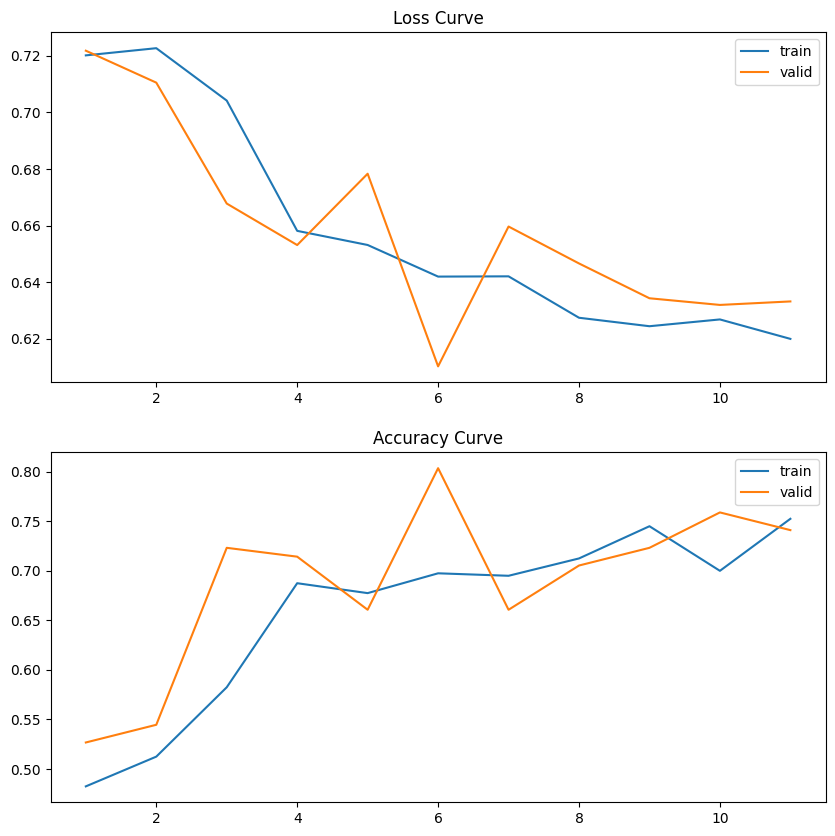

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot([i+1 for i in range(0, 11)], TRAIN_LOSS, label = 'train')
ax[0].plot([i+1 for i in range(0, 11)], VAL_LOSS, label='valid')
ax[0].set_title('Loss Curve')
ax[0].legend()


ax[1].plot([i+1 for i in range(0, 11)], TRAIN_ACC, label = 'train')
ax[1].plot([i+1 for i in range(0, 11)], VAL_ACC, label='valid')
ax[1].set_title('Accuracy Curve')
ax[1].legend()


In [21]:
torch.save(best_model.state_dict(), "bert_uncased.pth")
print("Model state dictionary saved to 'model.pth'")


Model state dictionary saved to 'model.pth'


## Ending notes:
The not so cool part ends here. Whats next? This model isn't as great and has too many trainable paramaters which is not quite desireable when working with larger models (>2GB).

The fun task next, is to create a Lora on top of this. Since the problem is too many training paramaters, slower inference time and slower convergence. We will use the saved not so good model from this notebook and create a LORA adapter for the same task.